In [6]:
A = 406.4
B = 410.7

alpha = 0.34
beta = 0.28

In [15]:
# loss as a function of params and data
# cf. eqn 10, https://arxiv.org/pdf/2203.15556.pdf

def l(n, d, A_=A, B_=B, alpha_=alpha, beta_=beta):
    # n, d in billions
    n = n * 1e9
    d = d * 1e9
    return 1.69 + A_/(n ** alpha_) + B_/(d ** beta_)

# compute (flops) as a function of params and data
# cf. table A4, https://arxiv.org/pdf/2203.15556.pdf

def flops(n, d):
    # n, d in billions
    n = n * 1e9
    d = d * 1e9
    return 6 * n * d

In [13]:
# table 1, https://arxiv.org/pdf/2203.15556.pdf

# (n, d)
# jurassic omitted b/c too close to gpt3
model_hparams = dict(
    lamda=(137, 168),
    gpt3=(175, 300),
#     jurassic=(178, 300),
    gopher=(280, 300),
    mt_nlg=(530, 270),
    chinchilla=(70, 1400),
    palm=(540, 780),
)

In [16]:
print('Predicted losses by model')
for name, (n, d) in model_hparams.items():
    print((name, l(n, d)))

Predicted losses by model
('lamda', 2.0518647617856733)
('gpt3', 2.0022879365177095)
('gopher', 1.9932584616598494)
('mt_nlg', 1.9906149887818265)
('chinchilla', 1.9366454705587173)
('palm', 1.923874449165463)


In [17]:
print('Approx FLOPS by model')
for name, (n, d) in model_hparams.items():
    print((name, flops(n, d)))

Approx FLOPS by model
('lamda', 1.38096e+23)
('gpt3', 3.15e+23)
('gopher', 5.04e+23)
('mt_nlg', 8.586e+23)
('chinchilla', 5.88e+23)
('palm', 2.5272e+24)


In [18]:
import pandas as pd

df = pd.DataFrame(model_hparams, index=['n', 'd']).T

df['scaling_loss'] = [l(n, d) for n, d in zip(df.n, df.d)]
df['flops'] = [flops(n, d) for n, d in zip(df.n, df.d)]

In [20]:
df

,n,d,scaling_loss,flops
lamda,137,168,2.051865,1.380960e+23
gpt3,175,300,2.002288,3.150000e+23
gopher,280,300,1.993258,5.040000e+23
mt_nlg,530,270,1.990615,8.586000e+23
chinchilla,70,1400,1.936645,5.880000e+23
palm,540,780,1.923874,2.527200e+24


In [19]:
NMIN, NMAX, DMIN, DMAX = 30, 1600, 100, 1600


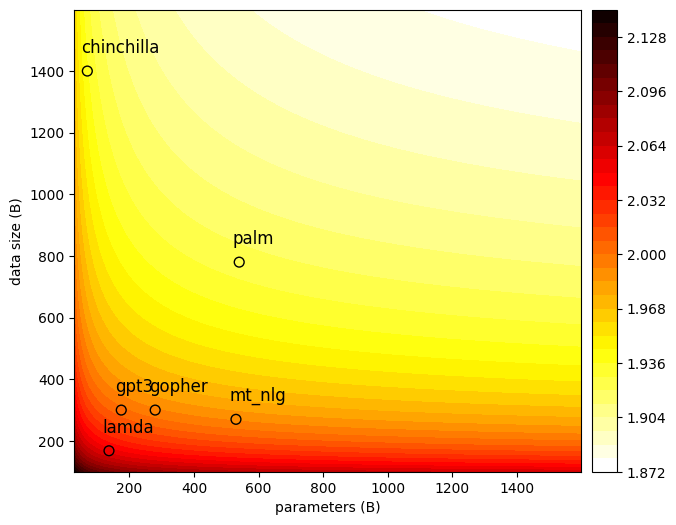

In [27]:
# import colorcet
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

ns, ds = np.meshgrid(np.arange(NMIN, NMAX, 1), np.arange(DMIN, DMAX, 1))

lgrid =  l(ns, ds)

fig = plt.figure(figsize=(7,6))

shared_kwargs = dict(cmap='hot_r', vmin=lgrid.min(), vmax=lgrid.max())

im = plt.contourf(ns, ds, lgrid, levels=40, **shared_kwargs)

ax = plt.gca()
plt.xlabel('parameters (B)')
plt.ylabel('data size (B)')

x_off = NMIN
y_off = DMIN

pcolor = 'k'

ax.scatter(df.n, df.d, c=df.scaling_loss, lw=1, edgecolors=pcolor, s=50, **shared_kwargs)

for name in df.index:
    plt.text(
        df.loc[name, 'n'] - 20, df.loc[name, 'd'] + 60, name, 
        fontdict=dict(fontsize=12, color=pcolor)
    )

ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="5%", pad="2%")
cb1 = fig.colorbar(im, cax=cax)

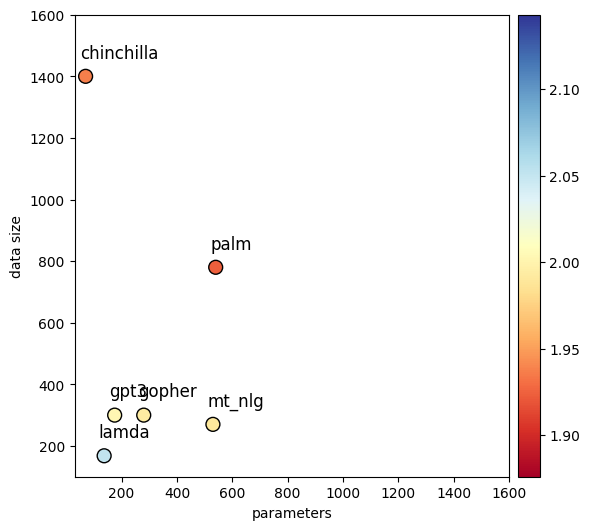

In [29]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

fig = plt.figure(figsize=(6,6))
im = plt.scatter(df.n, df.d, c=df.scaling_loss, lw=1, edgecolors='k', s=100, cmap='RdYlBu', vmin=lgrid.min(), vmax=lgrid.max());


for name in df.index:
    plt.text(df.loc[name, 'n'] - 20, df.loc[name, 'd'] + 60, name, fontdict=dict(fontsize=12))
    
plt.axis([NMIN, NMAX, DMIN, DMAX]);
plt.xlabel('parameters')
plt.ylabel('data size')

ax = plt.gca()
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="5%", pad="2%")
cb1 = fig.colorbar(im, cax=cax)

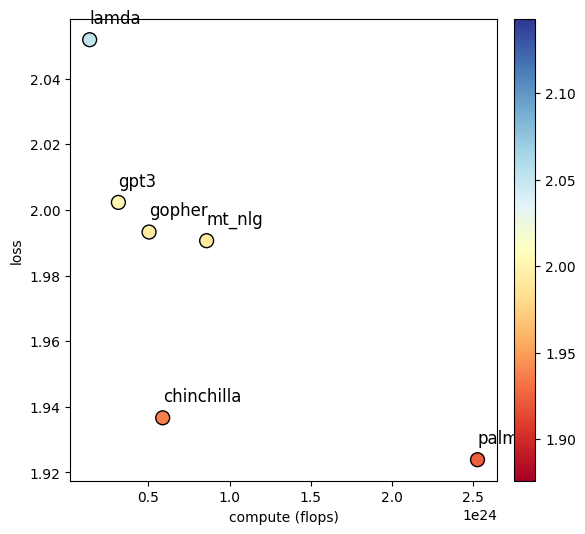

In [31]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

fig = plt.figure(figsize=(6,6))

im = plt.scatter(df.flops, df.scaling_loss, lw=1, c=df.scaling_loss, edgecolors='k', s=100, cmap='RdYlBu', vmin=lgrid.min(), vmax=lgrid.max());

for name in df.index:
    plt.text(df.loc[name, 'flops'] - 60, df.loc[name, 'scaling_loss'] + 0.005, name, fontdict=dict(fontsize=12))
    
plt.xlabel('compute (flops)')
plt.ylabel('loss')

ax = plt.gca()
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="5%", pad="4%")
cb1 = fig.colorbar(im, cax=cax)

In [33]:
# set n or d to infinity, by setting the corresponding term to 0

def l_infs(n, d, inf_n=False, inf_d=False):
    # n, d in billions
    n = n * 1e9
    d = d * 1e9
    return 1.69 + (1 - inf_n) * 406.4/(n ** 0.34) + (1 - inf_d) * 410.7/(d ** 0.28)

In [34]:
inf_losses_n = {}
inf_losses_d = {}
for name in df.index:
    if name in {'lamda', 'gpt3'}:
        continue
        
    inf_losses_n[name] = {
        'data': model_hparams[name][1], 
        'scaling_loss': l_infs(*model_hparams[name])
    }
    inf_losses_n[f'{name} (∞ params)'] = {
        'data': model_hparams[name][1], 
        'scaling_loss': l_infs(*model_hparams[name], inf_n=True)
    }
    

    inf_losses_d[f'{name} (∞ data)'] = {
        'params': model_hparams[name][0], 
        'scaling_loss': l_infs(*model_hparams[name], inf_d=True)
    }

df_inf_losses_n = pd.DataFrame(inf_losses_n).T
df_inf_losses_d = pd.DataFrame(inf_losses_d).T

In [35]:
df_inf_losses_n

,data,scaling_loss
gopher,300.0,1.993258
gopher (∞ params),300.0,1.941149
mt_nlg,270.0,1.990615
mt_nlg (∞ params),270.0,1.948668
chinchilla,1400.0,1.936645
chinchilla (∞ params),1400.0,1.853158
palm,780.0,1.923874
palm (∞ params),780.0,1.882193


In [36]:
df_inf_losses_d

,params,scaling_loss
gopher (∞ data),280.0,1.742110
mt_nlg (∞ data),530.0,1.731947
chinchilla (∞ data),70.0,1.773487
palm (∞ data),540.0,1.731681


In [ ]:
plt.figure(figsize=(8, 8))

plt.scatter(df_inf_losses_d.params, df_inf_losses_d.scaling_loss,
            c=df_inf_losses_d.scaling_loss, lw=1, edgecolors='k', s=50, cmap='RdYlBu', vmin=1.72, vmax=1.99)
plt.xlabel('params (B)')

tyoff = 0.0075
txoff = -20
for i, name in enumerate(df_inf_losses_d.sort_values('scaling_loss').index):
    plt.text(df_inf_losses_d.loc[name, 'params'] + txoff,
             df_inf_losses_d.loc[name, 'scaling_loss'] + tyoff * (-2 if i % 2 else 1),
             name, fontdict=dict(fontsize=12))

plt.axhline(df_inf_losses_n.loc['chinchilla', 'scaling_loss'], c='k', ls='--', label='chinchilla', lw=1)
plt.axis((NMIN - 20, NMAX, 1.72 - 0.02, 1.99 + 0.02))

ax2 = plt.gca().twiny()

ax2.scatter(df_inf_losses_n.data, df_inf_losses_n.scaling_loss, 
            c=df_inf_losses_n.scaling_loss, lw=1, edgecolors='k', s=50, cmap='RdYlBu', vmin=1.72, vmax=1.99)

for i, name in enumerate(df_inf_losses_n.sort_values('scaling_loss').index):
    ax2.text(df_inf_losses_n.loc[name, 'data'] + txoff,
             df_inf_losses_n.loc[name, 'scaling_loss'] + tyoff * (1 if i % 2 else -1.5),
             name, fontdict=dict(fontsize=12))

ax2.set_xlabel('data (B)')